# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [4]:
# read the data
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])

In [5]:
# shapes
df.shape

(26496, 2)

In [6]:
# top 5
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [7]:
# check for missing
df.isnull().mean()

datetime      0.0
num_orders    0.0
dtype: float64

In [8]:
# check for duplicates
df.duplicated().sum()

0

In [9]:
# 5 point summary
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [11]:
# duration of the dataset
df['datetime'].min(), df['datetime'].max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

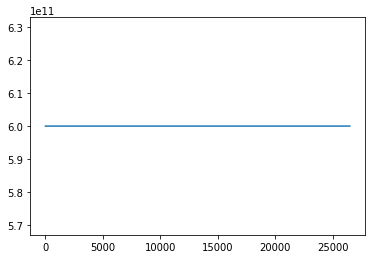

In [12]:
# check for gaps
(df['datetime'] - df['datetime'].shift()).plot()
plt.show()

**Conclusion**

1) There are 26496 orders captured at 10 minute intervals starting from 2018-03-01 to 2018-08-31.

2) There are no duplicates or misisng values

3) The datasets is time ordered and there are no gaps.

4) The mean number of orders is 14, and the ordes range from 0 - 119.

## Preparation and Analysis

#### Create new features

* Add date features (month, day, dayofweek, hour)
* Add rolling mean
* Add rolling median
* Add rolling std

In [13]:
# predictions are required for the next hour
df_hourly = df.copy(deep=True)
df_hourly.set_index('datetime', inplace=True)
df_hourly = df_hourly.resample('1H').sum()

In [14]:
def create_ts_features(df, dt_field, target, max_lag=1, rolling_window=1):
    """
    Create several Timseries features
    """
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(str(lag))] = df[target].shift(lag)
    
    df['rolling_mean'] = df[target].shift().rolling(rolling_window).mean()
    df['rolling_median'] = df[target].shift().rolling(rolling_window).median()
    df['rolling_std'] = df[target].shift().rolling(rolling_window).std()

In [15]:
create_ts_features(df_hourly, 'datetime', 'num_orders', max_lag=7, rolling_window=7)

In [16]:
df_hourly.head(8)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.142857,66.0,41.558908


#### Change the dtypes

In [17]:
df_hourly.describe()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
count,4416.000000,4416.000000,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4409.000000,4409.000000,4409.000000
mean,84.422781,5.505435,15.836957,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.331108,82.863688,30.913356
std,45.023853,1.713306,8.855229,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,31.807426,32.062825,14.822064
min,0.000000,3.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,17.000000,5.814596
25%,54.000000,4.000000,8.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.285714,61.000000,21.037382
50%,78.000000,5.500000,16.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.428571,78.000000,27.944673
75%,107.000000,7.000000,23.250000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,101.571429,101.000000,37.235416
max,462.000000,8.000000,31.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,254.142857,238.000000,151.400918


In [18]:
# before the change
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4416 non-null   int64  
 1   month           4416 non-null   int64  
 2   day             4416 non-null   int64  
 3   dayofweek       4416 non-null   int64  
 4   hour            4416 non-null   int64  
 5   lag_1           4415 non-null   float64
 6   lag_2           4414 non-null   float64
 7   lag_3           4413 non-null   float64
 8   lag_4           4412 non-null   float64
 9   lag_5           4411 non-null   float64
 10  lag_6           4410 non-null   float64
 11  lag_7           4409 non-null   float64
 12  rolling_mean    4409 non-null   float64
 13  rolling_median  4409 non-null   float64
 14  rolling_std     4409 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 552.0 KB


In [19]:
cols_to_change = [
                 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
                 'rolling_median'
]
df_hourly[cols_to_change] = df_hourly[cols_to_change].astype('Int16')

In [20]:
# after the change
df_hourly.describe()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
count,4416.000000,4416.000000,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4409.000000,4409.000000,4409.000000
mean,84.422781,5.505435,15.836957,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.331108,82.863688,30.913356
std,45.023853,1.713306,8.855229,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,31.807426,32.062825,14.822064
min,0.000000,3.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,17.000000,5.814596
25%,54.000000,4.000000,8.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.285714,61.000000,21.037382
50%,78.000000,5.500000,16.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.428571,78.000000,27.944673
75%,107.000000,7.000000,23.250000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,101.571429,101.000000,37.235416
max,462.000000,8.000000,31.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,254.142857,238.000000,151.400918


In [21]:
# after the change
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4416 non-null   int64  
 1   month           4416 non-null   int64  
 2   day             4416 non-null   int64  
 3   dayofweek       4416 non-null   int64  
 4   hour            4416 non-null   int64  
 5   lag_1           4415 non-null   Int16  
 6   lag_2           4414 non-null   Int16  
 7   lag_3           4413 non-null   Int16  
 8   lag_4           4412 non-null   Int16  
 9   lag_5           4411 non-null   Int16  
 10  lag_6           4410 non-null   Int16  
 11  lag_7           4409 non-null   Int16  
 12  rolling_mean    4409 non-null   float64
 13  rolling_median  4409 non-null   Int16  
 14  rolling_std     4409 non-null   float64
dtypes: Int16(8), float64(2), int64(5)
memory usage: 379.5 KB


#### Plot time-series orders using different intervals

In [22]:
def plot_orders(dfs, field, r=1, c=1, figsize=(12, 10), is_mean_window=False,
                window=1, titles=[], sup_title=None):
    """
    Plot mean orders based on different time intervals
    """
    fig, axes = plt.subplots(r, c, figsize=figsize)
    if not is_mean_window:
        for idx, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
            sns.lineplot(df.index, df, ax=ax)
            axes[idx].set_title(title)
    else:
        for idx, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
            sns.lineplot(df.index, df, ax=ax, label='hourly trend')
            sns.lineplot(df.index, df.shift().rolling(window).mean(), ax=ax, label='mean')
            sns.lineplot(df.index, df.shift().rolling(window).std(), ax=ax, label='std')
            axes[idx].set_title(title)
    axes.flat[-1].set_visible(False) 
    plt.suptitle(sup_title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [23]:
# resample the dataframe on an hourly, daily, and monthly basis
hourly_orders = df.set_index('datetime')['num_orders'].resample('1H').mean()
daily_orders = df.set_index('datetime')['num_orders'].resample('1D').mean()
monthly_orders = df.set_index('datetime')['num_orders'].resample('1M').mean()

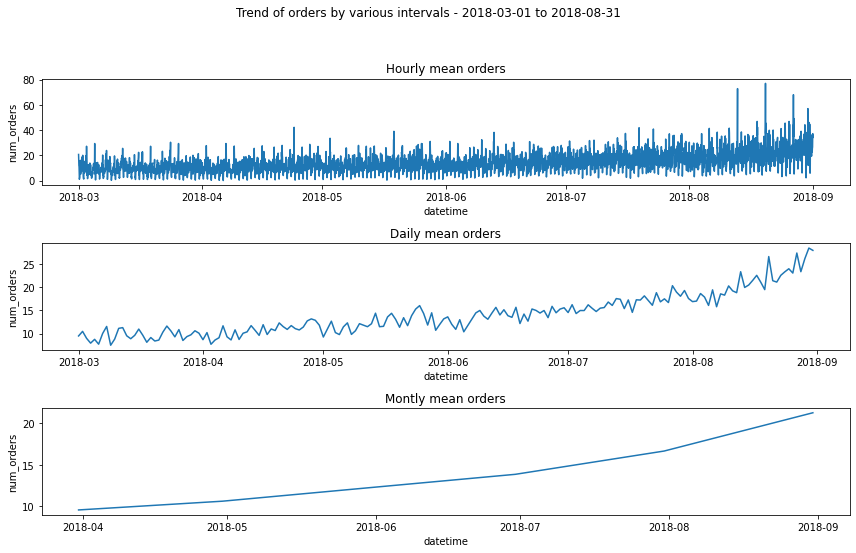

In [24]:
resample_df_list = [hourly_orders, daily_orders, monthly_orders]
titles = ['Hourly mean orders',
         'Daily mean orders',
         'Montly mean orders'
         ]
sup_title = 'Trend of orders by various intervals - 2018-03-01 to 2018-08-31'
plot_orders(resample_df_list, 'num_orders', r=4, c=1, titles=titles, sup_title=sup_title)

1) The overall trend reveals an upward trend in mean orders between 2018-03-01 and 2018-08-31.

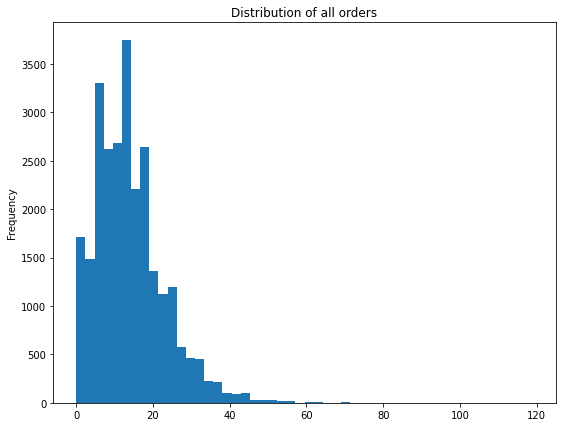

In [25]:
plt.subplots(figsize=(9, 7))
df['num_orders'].plot(kind='hist', bins=50, title='Distribution of all orders')
plt.show()

1) The histogram reveals a right-skewed distribution, which peaks at 9-12 orders.

#### Heatmap of orders by hour of day and day of week

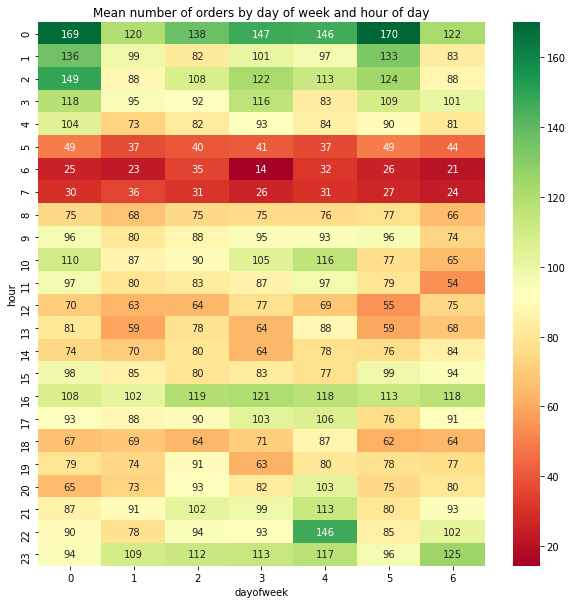

In [26]:
pivoted_df = df_hourly.pivot_table(index=['hour'], columns=['dayofweek'], values=['num_orders'], aggfunc='mean')
pivoted_df = pivoted_df.droplevel(0, axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(pivoted_df, annot=True, cmap="RdYlGn", fmt=".0f")
plt.title('Mean number of orders by day of week and hour of day')
plt.show()

1) Between 5AM -7 AM, the mean order of requests drops, and this pattern is observed throughout the week.

2) 12AM sees a higher than average number of orders compared to any other hour during any given week.

3) Between 8AM - 8PM, the number of rides is around the mean of 15.

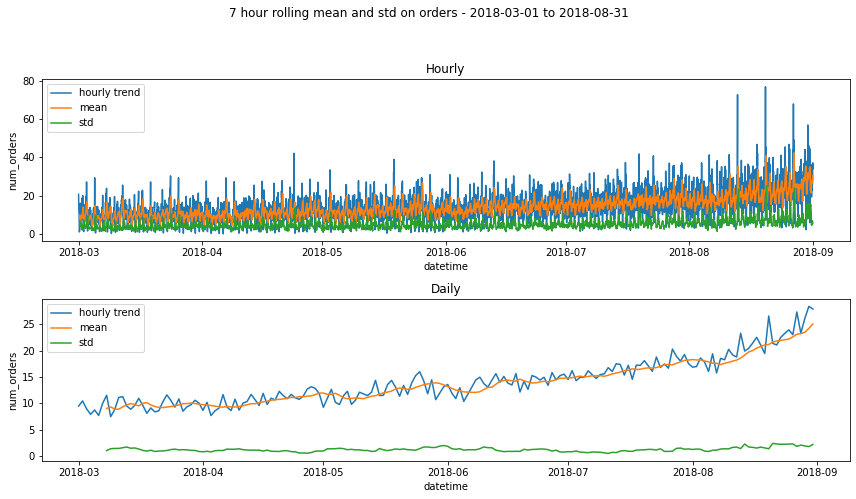

In [27]:
resample_df_list = [hourly_orders, daily_orders]
titles = [
         'Hourly',
         'Daily'
         ]
window = 7
sup_title = f'{window} hour rolling mean and std on orders - 2018-03-01 to 2018-08-31'
plot_orders(resample_df_list, 'num_orders', r=3, c=1, is_mean_window=True, window=window, 
            titles=titles, sup_title=sup_title)

1) The hourly data appears noisy, and the 7 hour mean, and std are noisy. However, in the daily orders, the std appears
constant, and the mean is relatively smoother.

#### Decompose the timeseries components

In [28]:
df_hourly = df_hourly.dropna()

In [29]:
df_hourly.shape

(4409, 15)

In [31]:
decomposed = seasonal_decompose(df_hourly[['num_orders']])

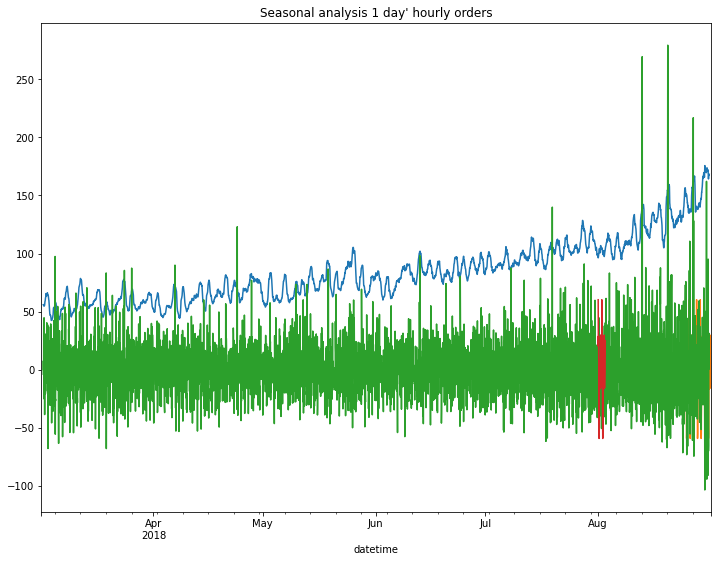

In [32]:
decomposed.trend.plot(figsize=(12, 9), title='Trend analysis of hourly orders')
decomposed.seasonal.tail(24*7).plot(figsize=(12, 9), title="Seasonal analysis of last 7 days' hourly orders")
decomposed.resid.plot(figsize=(12, 9), title="Residual plot of hourly orders")
decomposed.seasonal['2018-08-01': '2018-08-02'].plot(figsize=(12, 9), title="Seasonal analysis 1 day' hourly orders")
plt.show()

1) The trend plot shows an upward trend.

2) The seasonal trend for last 7 days shows that there is a daily seasonal pattern in ridership.

3) The residuals shows that the residual mean is not 0, which indicates that there could be a bias in the predictions. The spikes in August clearly indicate that the company was peaking with respect to ridership frequency.

4) The seasonal analysis for 1 day shows that ridership frequency increases at midnight, drops to its lowest at 6AM, and then
rises moderately around 5PM.

## Training

In [33]:
def rmse(y_true, y_pred):
    """
    Make scorer to compute rmse
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [34]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'catboost':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_rmse = rmse(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

In [35]:
# split the dataframe
train_X, test_X, train_y, test_y = train_test_split(df_hourly.drop(['num_orders'], axis=1), 
                                              df_hourly['num_orders'], 
                                              test_size=0.2,
                                              random_state=42, shuffle=False)

In [36]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((3527, 14), (882, 14), (3527,), (882,))

In [37]:
tscv = TimeSeriesSplit(n_splits=5)

In [38]:

lr = LinearRegression()
best_lr_model, best_lr_rmse, best_lr_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={}, 
                scoring=make_scorer(rmse), cv=tscv)

In [ ]:
rf = RandomForestRegressor(random_state=42)
best_rf_model, best_rf_rmse, best_rf_time = build_model(rf, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'n_estimators': range(100, 600, 100),
                                                                        'max_depth': range(5, 10)
                                                                        }, 
                scoring=make_scorer(rmse), cv=tscv)

In [39]:
# cat_features = ['month', 'hour', 'day', 'dayofweek']
cat_features = []
cat = CatBoostRegressor(learning_rate=0.1, loss_function='RMSE',
                        random_seed=42)
best_cb_model, best_cb_rmse, best_cb_time = build_model(cat, train_X.values, train_y.values, 
                                                        test_X.values, test_y.values,
                                                        hyperparameters={'iterations': range(100, 600, 100),
                                                                        'depth': range(5, 10)}, 
                scoring=make_scorer(rmse), cv=tscv, model_str='catboost',
           cat_features=cat_features)

0:	learn: 28.1671839	total: 47.8ms	remaining: 4.73s
1:	learn: 26.8663699	total: 49.4ms	remaining: 2.42s
2:	learn: 26.2444481	total: 51ms	remaining: 1.65s
3:	learn: 25.0861485	total: 52.6ms	remaining: 1.26s
4:	learn: 24.3981393	total: 54.4ms	remaining: 1.03s
5:	learn: 23.7346980	total: 56.1ms	remaining: 879ms
6:	learn: 22.9945552	total: 57.8ms	remaining: 767ms
7:	learn: 22.3026165	total: 59.4ms	remaining: 683ms
8:	learn: 21.5301371	total: 61.2ms	remaining: 618ms
9:	learn: 20.8937836	total: 62.8ms	remaining: 566ms
10:	learn: 20.4174489	total: 64.5ms	remaining: 522ms
11:	learn: 19.9889727	total: 66.2ms	remaining: 486ms
12:	learn: 19.6914336	total: 67.8ms	remaining: 454ms
13:	learn: 19.3357131	total: 69.6ms	remaining: 428ms
14:	learn: 19.0968660	total: 71.3ms	remaining: 404ms
15:	learn: 18.8685419	total: 73ms	remaining: 383ms
16:	learn: 18.5908615	total: 74.6ms	remaining: 364ms
17:	learn: 18.3957632	total: 76.3ms	remaining: 347ms
18:	learn: 18.1719507	total: 77.9ms	remaining: 332ms
19:	lea

KeyboardInterrupt: 

In [ ]:
model_results_df = pd.DataFrame({'model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
              'best_rmse': [best_lr_rmse, best_rf_rmse, best_cb_rmse],
              'train_time': [best_lr_time, best_rf_time, best_cb_time]})

In [ ]:
model_results_df

In [119]:
# best CatBoostRegressor model params
best_cb_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 500,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.1000000015,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'approx_on_full_history': False,
 'subsample': 0.8000000119,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 8,
 'has_time': False,
 'fold_len_multiplier': 2,
 'border_count': 254,
 'classes_count': 0,
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'loss_function': 'RMSE',
 'learning_rate': 0.1000000015,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'MVS',
 'permutation_count': 4}

1) 3 models were trained and tested in using grid search based on number of iterations and depth_size using 5 fold
time-series cross validation; the end result is that CatBoostRegressor had the lowest RMSE of all 3 models, although
the training time it took is also among the highest at 780 seconds.

## Testing

In [ ]:
def test_prediction(model, test_X, test_y):
    """
    Predict RMSE on the test set
    """
    start_time = time.time()
    preds = model.predict(test_X)
    return preds, np.round(time.time(), 2) - start_time, rmse(test_y, preds)

In [ ]:
preds, pred_time, best_rmse = test_prediction(best_cb_model, test_X.values, test_y)
print(f'The RMSE on the test set is {np.round(best_rmse, 2)}, and time to predict {np.round(pred_time, 4)} seconds')

#### Feature importance

In [ ]:
pd.DataFrame(best_cb_model.feature_importances_,
index=train_X.columns, columns=['score']).sort_values('score', ascending=False)

1) The RMSE on the test set, using the model with the lowest RMSE, is 45 orders.

2) The top 3 important features are: hour, lag_1, month.

In [ ]:
len(preds)

In [ ]:
test_set = test_X.merge(df_hourly['num_orders'], left_index=True, right_index=True)['num_orders']
pd.DataFrame(test_set, columns=['num_orders'])
#test_set['preds'] = preds[0]
#test_set

**Summary**

1) The mean `num_orders` shows an upward trend in the last 5 months between 2018-03-01 and 2018-08-31.

2) The data was prepared by creating several date and time-series related features, such as, `month`, `day`, `dayofweek`, `hour`, 
`lag_*`, `rolling_mean`, `rolling_median`, and `rolling_std`.

3) The decomposition of time-series components shows a daily seasonality, which peaks at 12 AM, and drops to its lowest at 6AM, and
during the day peaks at around 5PM.

4) The residuals reveals that the mean is not 0, which could bias the forecast.

5) CatBoostRegressor emerged as the best model with the lowest RMSE. However, it also took the longest to train the model.
